In [57]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import community
import matplotlib.pyplot as plt

from pyod.models.cblof import CBLOF
from sklearn.preprocessing import LabelEncoder

In [58]:
data_folder = '/home/sunilkarki/Documents/Persn/CProj/bnp/data'

file_path = os.path.join(data_folder, 'transactions1.csv')
blockchain_data = pd.read_csv(file_path)

In [59]:
# Load your blockchain data into a DataFrame (replace 'your_data.csv' with your actual file name or data source)
# blockchain_data = pd.read_csv('your_data.csv')

# Convert hex values to label encoded numeric values
label_encoder = LabelEncoder()

blockchain_data['From'] = label_encoder.fit_transform(blockchain_data['From'])
blockchain_data['To'] = label_encoder.fit_transform(blockchain_data['To'])

blockchain_data['Value (ETH)'] = pd.to_numeric(blockchain_data['Value (ETH)'], errors='coerce')
# blockchain_data['Value (ETH)'] = blockchain_data['Value (ETH)'].div(1000000000000000000).round(4)
blockchain_data['Value (ETH)'] = (blockchain_data['Value (ETH)'] / 1000000000000000000).round(4)

# Select relevant columns for the analysis
selected_columns = ['From', 'To', 'Value (ETH)']
selected_data = blockchain_data[selected_columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


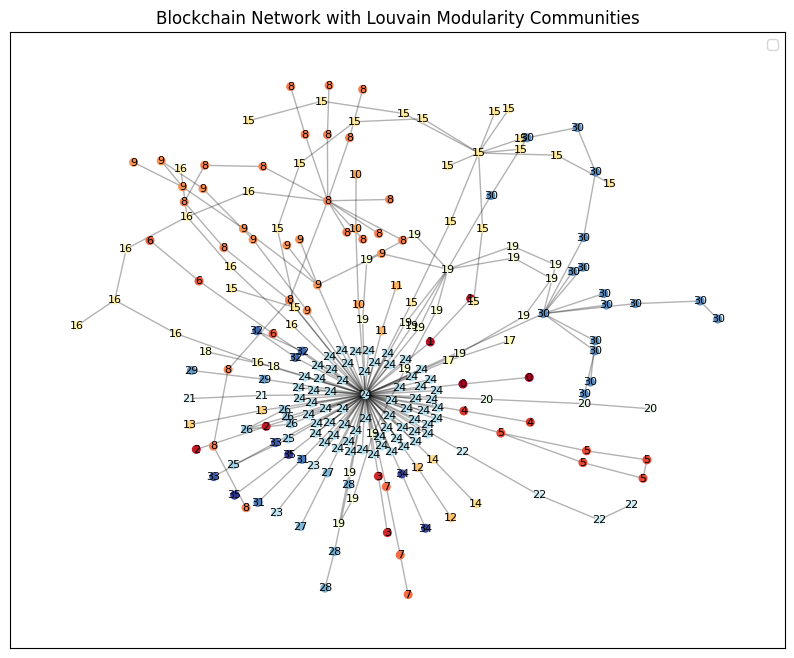

In [60]:

# Create a directed graph from the blockchain data
G = nx.from_pandas_edgelist(blockchain_data, 'From', 'To', ['Value (ETH)'], create_using=nx.Graph())

# Louvain Modularity for Community Detection
partition = community.best_partition(G)

# Add the community information to the blockchain data
blockchain_data['Community'] = blockchain_data['From'].map(partition)

# Visualize the network graph with communities and PageRank scores
pos = nx.spring_layout(G, seed=5, k=0.15)
plt.figure(figsize=(10, 8))

# Draw nodes colored by community
nx.draw_networkx_nodes(G, pos, node_size=30, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))

# Draw edges
nx.draw_networkx_edges(G, pos, width=1, alpha=0.3)
# nx.draw_networkx_edges(G, pos, width=1, ax=ax)

# Draw community labels
nx.draw_networkx_labels(G, pos, labels=partition, font_size=8)

plt.title("Blockchain Network with Louvain Modularity Communities")
plt.legend()
plt.show()


In [61]:
blockchain_data.head

<bound method NDFrame.head of      Block Number                                   Transaction Hash  From  \
0        17140930  0xa7af6f90a8cd6a7d5279a050af0f43061194632d9021...    80   
1        17140930  0xcc784b110da9733eff91a98317c69120a90895ee8f5e...   174   
2        17140930  0xdeca1a9a4b3d9b455fa8fc8b1983ba35cb49cdb4d4fd...   211   
3        17140930  0x3d5753ff616de541fd04be5b9d1394cae7f498b20ee6...    88   
4        17140930  0x2bcbbdecb2a8728a840cbe30d11373cc816dc9e7030c...   107   
..            ...                                                ...   ...   
245      17140930  0xa006b808a421a136a6256bc425a0f45aab5f55749407...   193   
246      17140930  0x0c92e1377a45bb98e3d3fe0f7f2632f1a90d8f297c97...   166   
247      17140930  0x7a79d81b7f3fcccbf2b3937930eacd2658eba0a2e46a...    37   
248      17140930  0x3e3e43e746a7a23c0547e987d2ea3c1875987422f4c0...   226   
249      17140930  0x5995a40d473fbc131148e36a6f4443240d224de1f378...    30   

     To  Value (ETH)   Timestamp 

In [62]:

# CBLOF for Anomaly Detection
X = selected_data.values

# Normalize the 'Value (ETH)' column to ensure a consistent scale for CBLOF
# X[:, -1] = (X[:, -1] - X[:, -1].min()) / (X[:, -1].max() - X[:, -1].min())

# Train CBLOF model
cblof_model = CBLOF()
cblof_model.fit(X)

# Predict outliers
outliers = cblof_model.predict(X)

# Add anomaly information to the blockchain data
blockchain_data['Anomaly'] = outliers

# Display the blockchain data with community and anomaly information
blockchain_data

/home/sunilkarki/Documents/Persn/CProj/bnp/virtualenvs/.py3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Block Number,Transaction Hash,From,To,Value (ETH),Timestamp,Community,Anomaly
0,17140930,0xa7af6f90a8cd6a7d5279a050af0f43061194632d9021...,80,52,0.1500,1682640023,15,0
1,17140930,0xcc784b110da9733eff91a98317c69120a90895ee8f5e...,174,54,0.2500,1682640023,1,0
2,17140930,0xdeca1a9a4b3d9b455fa8fc8b1983ba35cb49cdb4d4fd...,211,87,1.4924,1682640023,2,1
3,17140930,0x3d5753ff616de541fd04be5b9d1394cae7f498b20ee6...,88,42,0.0421,1682640023,8,0
4,17140930,0x2bcbbdecb2a8728a840cbe30d11373cc816dc9e7030c...,107,14,1.3592,1682640023,19,0
...,...,...,...,...,...,...,...,...
245,17140930,0xa006b808a421a136a6256bc425a0f45aab5f55749407...,193,38,0.0220,1682640023,25,0
246,17140930,0x0c92e1377a45bb98e3d3fe0f7f2632f1a90d8f297c97...,166,56,0.0145,1682640023,13,0
247,17140930,0x7a79d81b7f3fcccbf2b3937930eacd2658eba0a2e46a...,37,86,0.0300,1682640023,30,0
248,17140930,0x3e3e43e746a7a23c0547e987d2ea3c1875987422f4c0...,226,35,0.1500,1682640023,8,0


In [63]:
# Finding anomalies by CBLOF

anomaly_data_by_cblof = blockchain_data[blockchain_data['Anomaly'] != 0]

# Display the filtered data
anomaly_data_by_cblof

,Block Number,Transaction Hash,From,To,Value (ETH),Timestamp,Community,Anomaly
2,17140930,0xdeca1a9a4b3d9b455fa8fc8b1983ba35cb49cdb4d4fd...,211,87,1.4924,1682640023,2,1
13,17140930,0xa8e815082279e310e03ee52c553c972dcf76b37d6ba7...,177,83,0.0072,1682640023,12,1
16,17140930,0xdceee6db33d7d351f06b15bb8a8e848693634706553f...,6,63,0.7651,1682640023,8,1
18,17140930,0xf3854cce81b1f37e912209b5b03ae39997c9d79b5495...,225,63,0.4656,1682640023,8,1
25,17140930,0x905a2bd252a032ad146b383f6ca6b682cb272b64361b...,190,86,0.1500,1682640023,30,1
35,17140930,0x596c2184c75d8b14f7fc93cc3a9025c33f3499ee083d...,216,106,0.0425,1682640023,17,1
36,17140930,0xd19ff5229107019c63fc89665b8d0b7b5dbd4c1debbd...,171,49,30.9761,1682640023,18,1
44,17140930,0x230f6d0b2f230298eb707d2f8b38f3b8cc1e5565f848...,170,77,0.3760,1682640023,21,1
51,17140930,0xc17335c921b1bf5e1bb16dabda8f5fadc0a642e83c04...,186,86,0.0800,1682640023,30,1
105,17140930,0xed23182104a6572c69e9587cf3e1a0690df558eed594...,229,95,0.0508,1682640023,31,1


In [64]:
# Finding anomalies by Page Rank

pagerank_scores = nx.pagerank(G)

# Add PageRank scores to the blockchain data
blockchain_data['PageRank'] = blockchain_data['From'].map(pagerank_scores)

# Identify anomalies based on PageRank scores
# You can set a threshold for PageRank scores to determine anomalies
threshold = 0.006
anomaly_data_by_pagerank = blockchain_data[blockchain_data['PageRank'] > threshold]

anomaly_data_by_pagerank

,Block Number,Transaction Hash,From,To,Value (ETH),Timestamp,Community,Anomaly,PageRank
27,17140930,0xb44280c92c0df5730ef572ddf89c38010e20dd606495...,8,62,0.1704,1682640023,9,0,0.006059
28,17140930,0xd7605f8f7731eaa6481182d620bb02fe541b1c9b2a16...,8,36,0.0334,1682640023,9,0,0.006059
45,17140930,0x5c11e22840a707f22473c5a824a409390f918b77452c...,52,61,0.0030,1682640023,15,0,0.019415
53,17140930,0xd2d516a93286e6c06f24ed7e4a889cf06a4a555d54cd...,22,25,0.0100,1682640023,24,0,0.194102
89,17140930,0x89689c7b7ca6abfbd726e9be9065409ee67d47d6a94a...,43,22,10.5191,1682640023,9,0,0.009024
90,17140930,0x89eadf1072a4448446b28b524ff9733eb27b377559d7...,13,22,0.3194,1682640023,8,0,0.007138
98,17140930,0x302db94e97ddf827854f51b214d02372c4a6b56289a6...,86,22,1.3940,1682640023,30,0,0.018363
104,17140930,0xe68fa4a555e2907457448768a34ce4f7a1ce2b0ed92a...,137,69,0.0150,1682640023,19,0,0.014279
155,17140930,0x009bd67baac24154fa92112053d771a551ed03781562...,137,97,0.0150,1682640023,19,0,0.014279
156,17140930,0x2768d1dc72eb91c1507114aa9275c3a8b12db68ca0c0...,137,72,0.0150,1682640023,19,0,0.014279


In [65]:
G = nx.from_pandas_edgelist(blockchain_data, 'From', 'To', ['Value (ETH)'], create_using=nx.DiGraph())

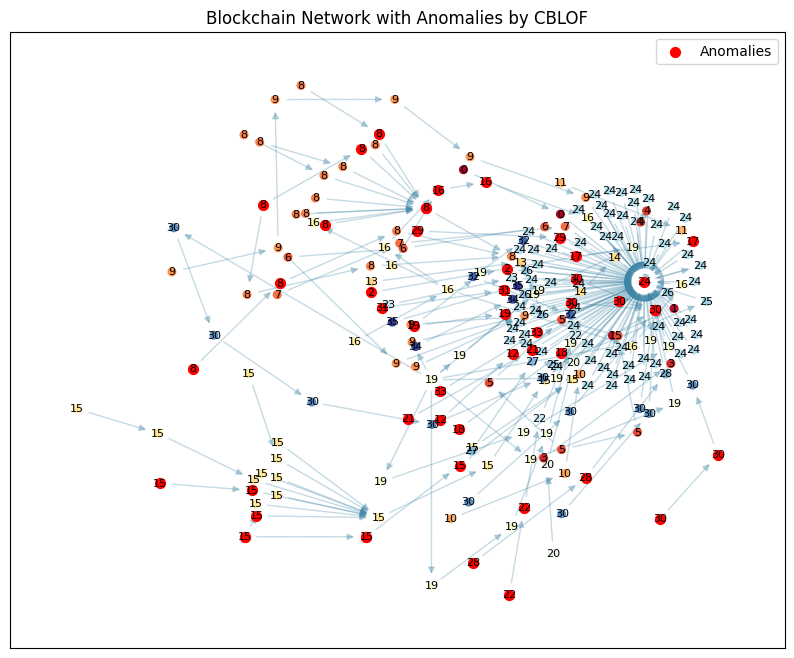

In [66]:
# CBLOF


# Visualize the network graph with communities
pos = nx.spring_layout(G, seed=5, k=0.15)
plt.figure(figsize=(10, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=30, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='#3f86a6')

# Draw community labels
nx.draw_networkx_labels(G, pos, labels=partition, font_size=8)

# Highlight anomalies with a different color or marker
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=anomaly_data_by_cblof['From'].tolist() + anomaly_data_by_cblof['To'].tolist(),
    node_size=50,
    node_color='red',
    label='Anomalies'
)

plt.title("Blockchain Network with Anomalies by CBLOF")
plt.legend()
plt.show()

In [67]:
G = nx.from_pandas_edgelist(blockchain_data, 'From', 'To', ['Value (ETH)'], create_using=nx.DiGraph())

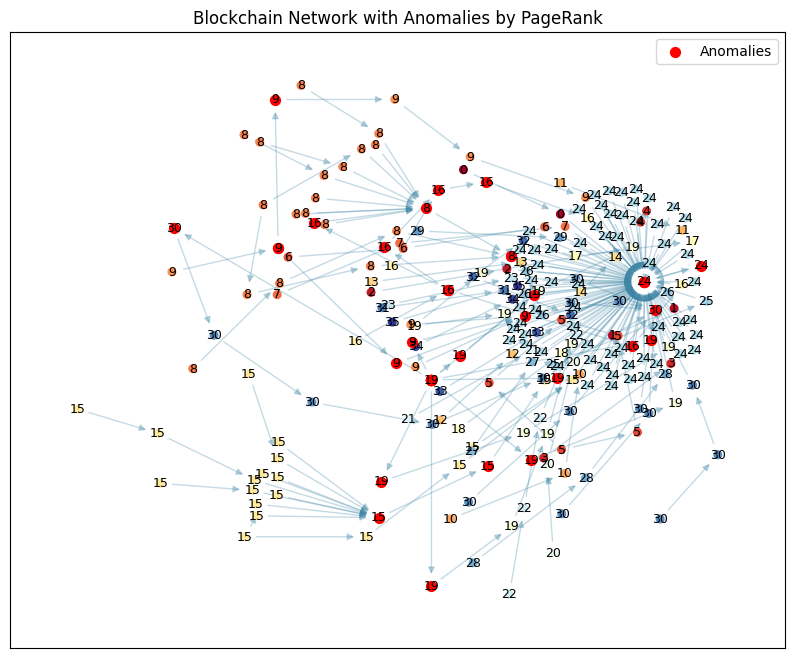

In [68]:
# PageRank


# Visualize the network graph with communities
pos = nx.spring_layout(G, seed=5, k=0.15)
plt.figure(figsize=(10, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=30, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='#3f86a6')

# Draw community labels
nx.draw_networkx_labels(G, pos, labels=partition, font_size=9)

# Highlight anomalies with a different color or marker
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=anomaly_data_by_pagerank['From'].tolist() + anomaly_data_by_pagerank['To'].tolist(),
    node_size=50,
    node_color='red',
    label='Anomalies'
)

plt.title("Blockchain Network with Anomalies by PageRank")
plt.legend()
plt.show()